## Avito Demand Prediction

### 1. Background

Avito.ru is a Russian classified advertisements website with sections devoted to general goods for sale, jobs, real estate, personals, cars for sale, and services. (from Wikipedia)

One of the challenges to Avito is to predict the demand of certain goods so that it can advise the sellers on the proper price. 



#### An advertisement in Avito looks like this:

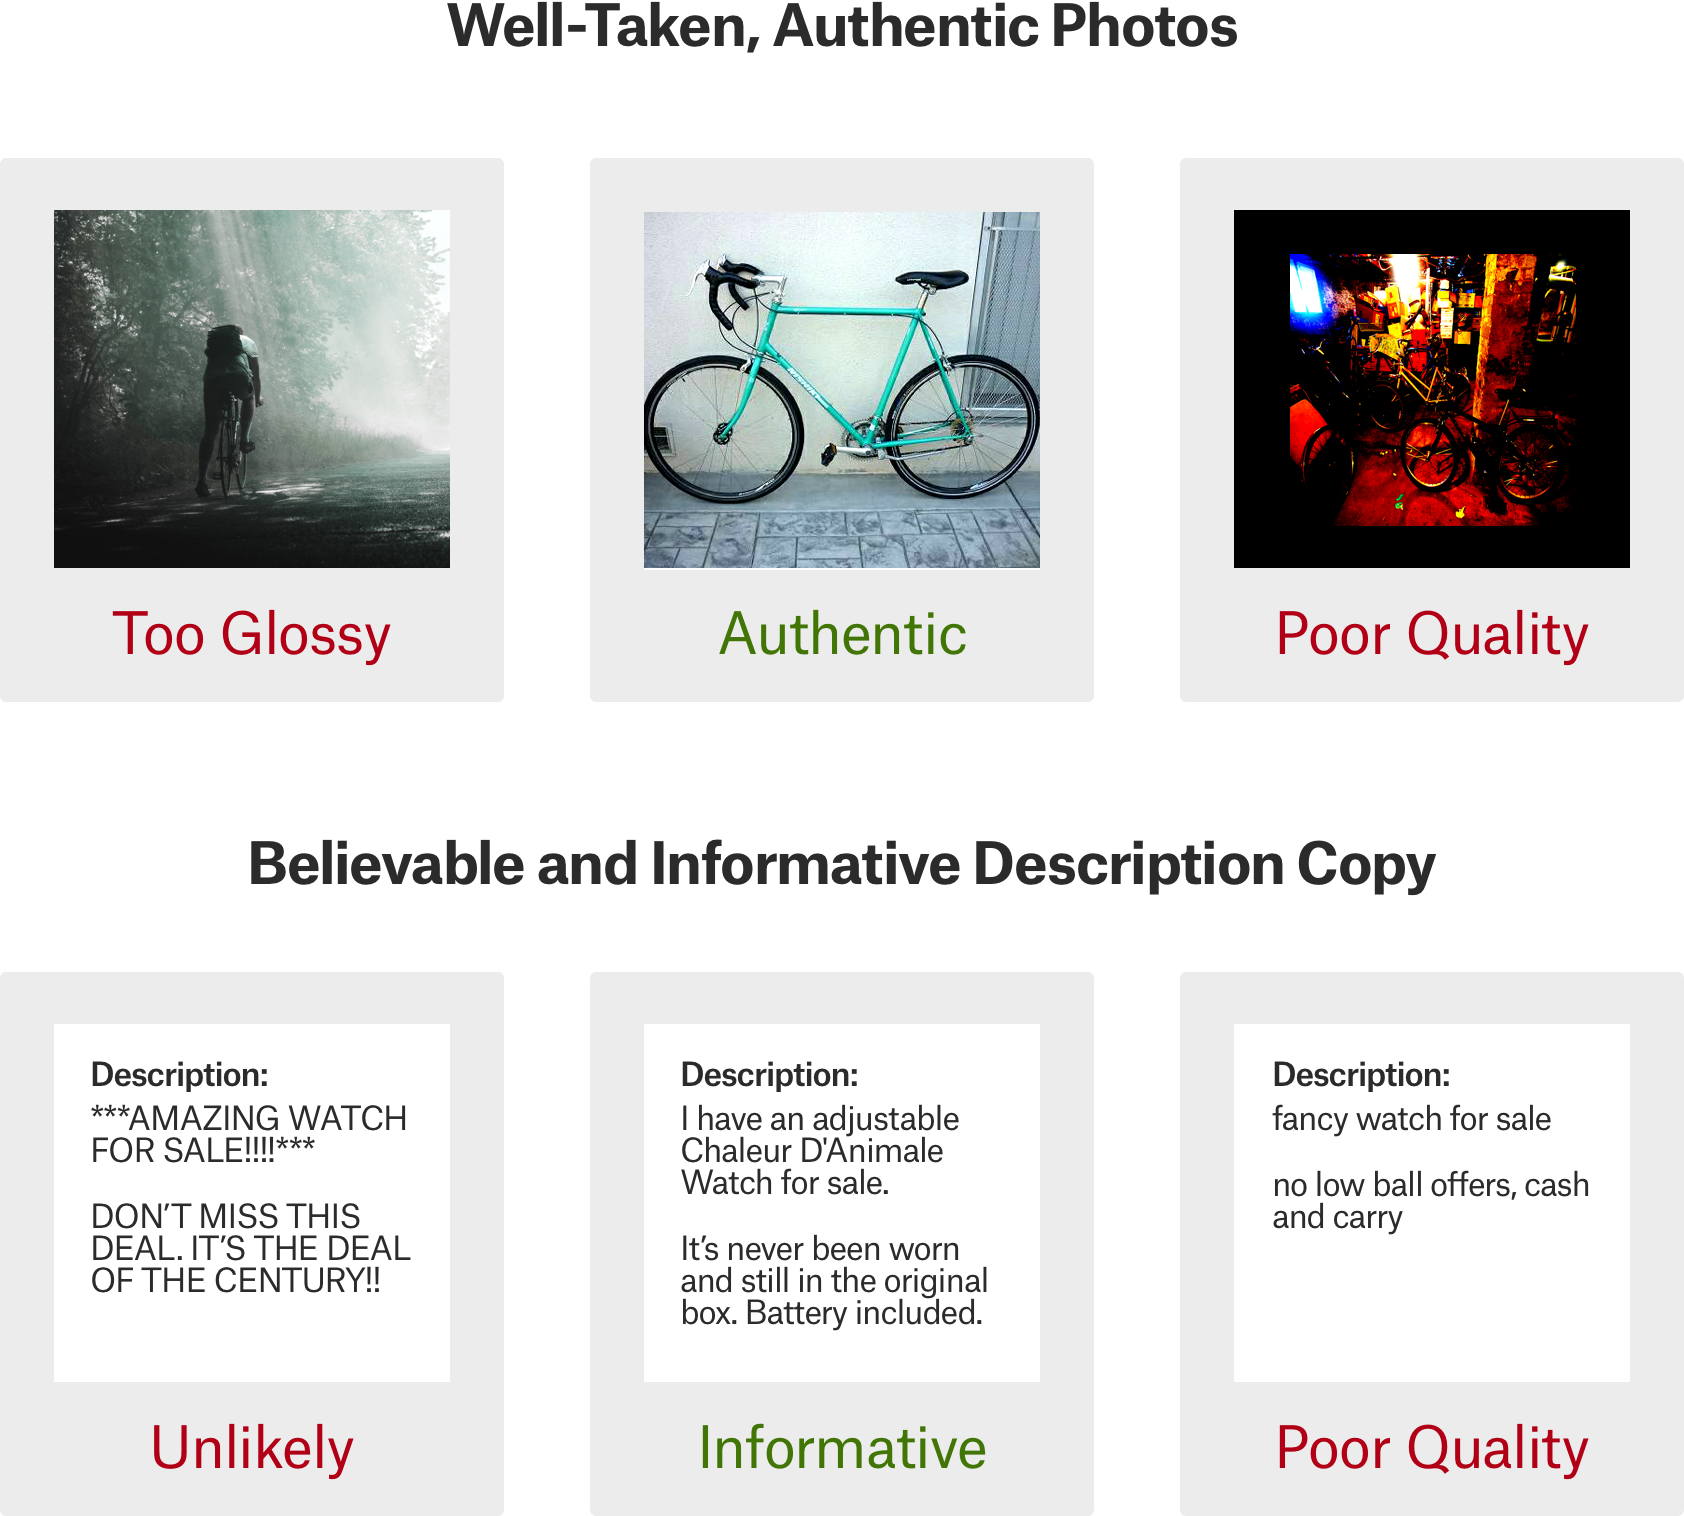

#### It contains the following information:

 - title, description
 - category of goods
 - price
 - image
 - general information like city, region, date
 

### 2. Task

You are asked to build a model to predict the **deal probability** of an advertisement. For deal probability, it is an internal estimation of Avito on whether a deal is done. For various reasons, it is not easy to conclude that a deal is done (as sellers can withdraw their advertisements without reason)

### 3. Purpose

The purpose of this demo is to walk you through the process we expect on your final project. It includes **Data Exploration** & **Modeling**. The dataset is provided by Kaggle and is publicly avabilable

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("../input/train.csv", parse_dates=["activation_date"])
# test_df = pd.read_csv("../input/test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
# print("Test file rows and columns are : ", test_df.shape)

Train file rows and columns are :  (1503424, 18)


# 1. feature meaning & relationships

### 1.1 understand the meaning of features

In [3]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


The train dataset description is as follows:

* item_id - Ad id.
* user_id - User id.
* region - Ad region.
* city - Ad city.
* parent_category_name - Top level ad category as classified by Avito's ad model.
* category_name - Fine grain ad category as classified by Avito's ad model.
* param_1 - Optional parameter from Avito's ad model.
* param_2 - Optional parameter from Avito's ad model.
* param_3 - Optional parameter from Avito's ad model.
* title - Ad title.
* description - Ad description.
* price - Ad price.
* item_seq_number - Ad sequential number for user.
* activation_date- Date ad was placed.
* user_type - User type.
* image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
* image_top_1 - Avito's classification code for the image.
* deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

So deal probability is our target variable and  is a float value between 0 and 1 as per the data page. Let us have a look at it. 

### 1.2 translate the text from russian to english

In [4]:
from io import StringIO

region_mapping = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(region_mapping)
train_df = pd.merge(train_df, region_df, how="left", on="region")

category_mapping = StringIO("""
category_name,category_name_en
"Одежда, обувь, аксессуары","Clothing, shoes, accessories"
Детская одежда и обувь,Children's clothing and shoes
Товары для детей и игрушки,Children's products and toys
Квартиры,Apartments
Телефоны,Phones
Мебель и интерьер,Furniture and interior
Предложение услуг,Offer services
Автомобили,Cars
Ремонт и строительство,Repair and construction
Бытовая техника,Appliances
Товары для компьютера,Products for computer
"Дома, дачи, коттеджи","Houses, villas, cottages"
Красота и здоровье,Health and beauty
Аудио и видео,Audio and video
Спорт и отдых,Sports and recreation
Коллекционирование,Collecting
Оборудование для бизнеса,Equipment for business
Земельные участки,Land
Часы и украшения,Watches and jewelry
Книги и журналы,Books and magazines
Собаки,Dogs
"Игры, приставки и программы","Games, consoles and software"
Другие животные,Other animals
Велосипеды,Bikes
Ноутбуки,Laptops
Кошки,Cats
Грузовики и спецтехника,Trucks and buses
Посуда и товары для кухни,Tableware and goods for kitchen
Растения,Plants
Планшеты и электронные книги,Tablets and e-books
Товары для животных,Pet products
Комнаты,Room
Фототехника,Photo
Коммерческая недвижимость,Commercial property
Гаражи и машиноместа,Garages and Parking spaces
Музыкальные инструменты,Musical instruments
Оргтехника и расходники,Office equipment and consumables
Птицы,Birds
Продукты питания,Food
Мотоциклы и мототехника,Motorcycles and bikes
Настольные компьютеры,Desktop computers
Аквариум,Aquarium
Охота и рыбалка,Hunting and fishing
Билеты и путешествия,Tickets and travel
Водный транспорт,Water transport
Готовый бизнес,Ready business
Недвижимость за рубежом,Property abroad
""")

temp_df = pd.read_csv(category_mapping)
train_df = pd.merge(train_df, temp_df, on="category_name", how="left")

parent_category_mapping = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

temp_df = pd.read_csv(parent_category_mapping)
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")

### 1.3 feature exploration

#### <font color=red> let's explore the feature you don't fully understand. e.g. whether **item_id** is an unique identifier or not </font>

In [5]:
train_df['item_id'].nunique()

1503424

In [6]:
train_df.shape

(1503424, 21)

#### <font color=red>same, so the item_id is a unique identifier</font>

#### <font color=red>suggestion: we should also explore the hierarchical relationships between features. e.g.</font>

    - whether a category_name belongs to only one parent_category_name?
    - the relationships between param_1, param_2, param_3

In [7]:
train_df.groupby('category_name')['parent_category_name'].nunique()

category_name
Автомобили                      1
Аквариум                        1
Аудио и видео                   1
Билеты и путешествия            1
Бытовая техника                 1
Велосипеды                      1
Водный транспорт                1
Гаражи и машиноместа            1
Готовый бизнес                  1
Грузовики и спецтехника         1
Детская одежда и обувь          1
Дома, дачи, коттеджи            1
Другие животные                 1
Земельные участки               1
Игры, приставки и программы     1
Квартиры                        1
Книги и журналы                 1
Коллекционирование              1
Коммерческая недвижимость       1
Комнаты                         1
Кошки                           1
Красота и здоровье              1
Мебель и интерьер               1
Мотоциклы и мототехника         1
Музыкальные инструменты         1
Настольные компьютеры           1
Недвижимость за рубежом         1
Ноутбуки                        1
Оборудование для бизнеса        1


#### <font color=red> True </font>

In [8]:
train_df.groupby('param_2')['param_1'].nunique().sort_values(ascending = False)

param_2
Другое                  7
Обувь                   4
Офисное помещение       4
Брюки                   4
Таунхаус                4
                       ..
Гарнитуры и наушники    1
РАФ                     1
Ремонт ванной           1
Вытяжки                 1
Юридические услуги      1
Name: param_1, Length: 271, dtype: int64

#### <font color=red>param_2 can have more than one param_1 values; so, param_2 is not a breakdown of param_1</font>

In [9]:
train_df.groupby('param_3')['param_2'].nunique().sort_values(ascending = False)

param_3
Другая         52
Без размера    16
Вторичка       11
48–50 (XL)     10
Новостройка    10
               ..
Passo Sette     1
Pathfinder      1
Patriot         1
Patrol          1
I35             1
Name: param_2, Length: 1219, dtype: int64

#### <font color=red>Similarly, param_3 is not a breakdown of param_2</font>

## 2. Data Type Check

In [10]:
train_df.dtypes

item_id                            object
user_id                            object
region                             object
city                               object
parent_category_name               object
category_name                      object
param_1                            object
param_2                            object
param_3                            object
title                              object
description                        object
price                             float64
item_seq_number                     int64
activation_date            datetime64[ns]
user_type                          object
image                              object
image_top_1                       float64
deal_probability                  float64
region_en                          object
category_name_en                   object
parent_category_name_en            object
dtype: object

### 2.1 some translation for param_1, param_2, param_3

 - param_1: bed dress, other, Video, DVD and Blu-ray players, car seats, With mileage, For girls, selling
 - param_2: footwear,
 - param_3, resale

#### <font color=red>seems like they are categorical; so, lets check the number of unique values</font>

In [11]:
train_df.shape

(1503424, 21)

In [12]:
train_df['param_1'].nunique()

371

In [13]:
train_df['param_1'].value_counts()

Женская одежда         226289
Для девочек            151979
Для мальчиков          117772
Продам                 113764
С пробегом              61024
                        ...  
Ла-перм лаперм              1
Уральский рекс              1
Бриар                       1
Французская овчарка         1
Лхаса Апсо                  1
Name: param_1, Length: 371, dtype: int64

In [14]:
train_df['param_2'].nunique()

271

In [15]:
train_df['param_2'].value_counts()

Обувь             150450
Верхняя одежда    141860
Платья и юбки      69483
Другое             36284
Трикотаж           31684
                   ...  
Doninvest              1
Tata                   1
Changan                1
Landwind               1
Trabant                1
Name: param_2, Length: 271, dtype: int64

In [16]:
train_df['param_3'].nunique()

1219

In [17]:
train_df['param_3'].value_counts()

Вторичка                50615
42–44 (S)               47915
44–46 (M)               35854
86-92 см (1-2 года)     29139
98-104 см (2-4 года)    25774
                        ...  
Today                       1
306                         1
Eterna                      1
Amigo                       1
Flying PickUp               1
Name: param_3, Length: 1219, dtype: int64

#### <font color=red> as the number of unique values is less than the number of records, very likely param1, param2, param3 are categorical</font>

In [18]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,region_en,category_name_en,parent_category_name_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,Sverdlovsk oblast,Children's products and toys,Personal belongings
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,Samara oblast,Furniture and interior,For the home and garden
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,Rostov oblast,Audio and video,Consumer electronics
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,Tatarstan,Children's products and toys,Personal belongings
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,Volgograd oblast,Cars,Transport


#### <font color=red>concludion: the data type of features:</font>

 - item_id, user_id: unique_identifier (string)
 - region, city, parent_category_name, category_name, user_type: categorical
 - param_1, param_2, param_3, title, description: text
 - price, item_seq_number: numeric
 - activation_date: date
 - image: unique identifier (for external dataset)

## 3. statistical report

### 3.1 basic stats

In [19]:
train_df.describe()

,price,item_seq_number,image_top_1,deal_probability
count,1.418062e+06,1.503424e+06,1.390836e+06,1.503424e+06
mean,3.167081e+05,7.436740e+02,1.241932e+03,1.391306e-01
std,6.689154e+07,5.572522e+03,9.704641e+02,2.600785e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+02,9.000000e+00,4.250000e+02,0.000000e+00
50%,1.300000e+03,2.900000e+01,1.057000e+03,0.000000e+00
75%,7.000000e+03,8.800000e+01,2.217000e+03,1.508700e-01
max,7.950101e+10,2.044290e+05,3.066000e+03,1.000000e+00


### 3.2 check categorical distribution

In [20]:
train_df.dtypes

item_id                            object
user_id                            object
region                             object
city                               object
parent_category_name               object
category_name                      object
param_1                            object
param_2                            object
param_3                            object
title                              object
description                        object
price                             float64
item_seq_number                     int64
activation_date            datetime64[ns]
user_type                          object
image                              object
image_top_1                       float64
deal_probability                  float64
region_en                          object
category_name_en                   object
parent_category_name_en            object
dtype: object

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def plt_categorical(feature_name):
    dist = train_df[feature_name].value_counts().to_frame('count')
    dist.reset_index(inplace = True)
    
    if dist.shape[0] > 40:
        dist = dist[:40]

    fig = plt.figure(figsize= (8, 8))
    sns.barplot(data = dist, x = 'count', y = 'index', palette="Blues_d")
    plt.title(feature_name)

In [22]:
categorical = ['region_en', 'city', 'parent_category_name_en', 'category_name_en', 'user_type']

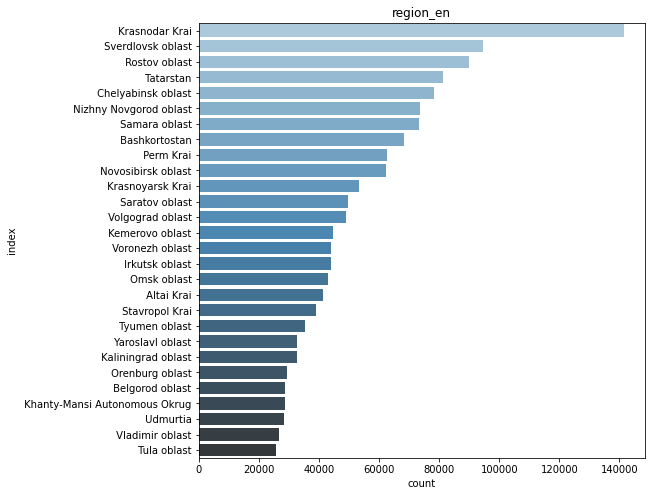

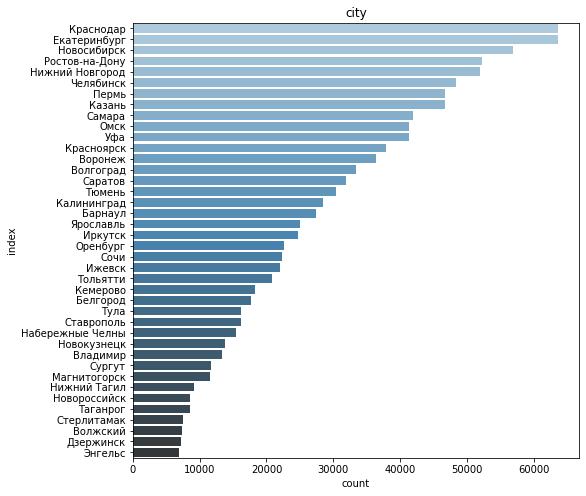

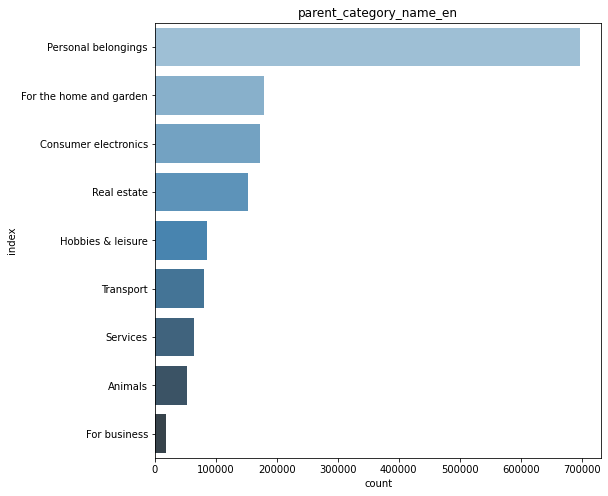

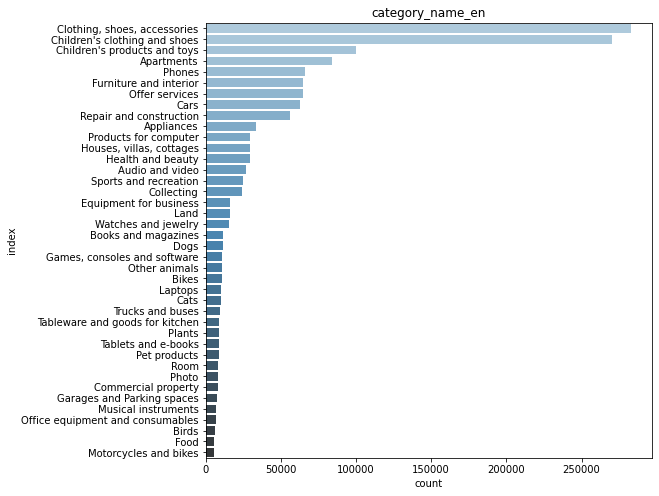

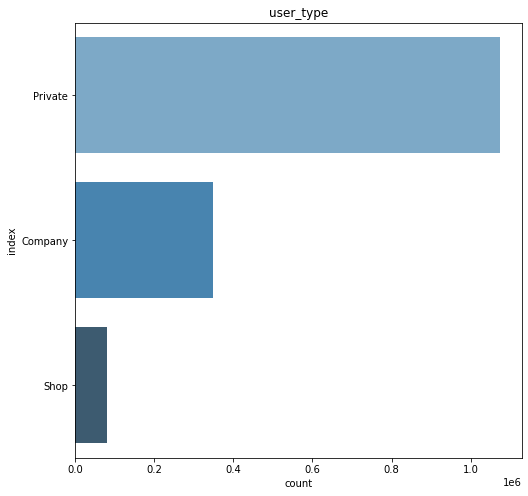

In [23]:
for each in categorical:
    plt_categorical(each)

### 3.3 check numeric distribution

In [24]:
def plt_numeric(feature_name):

    fig = plt.figure(figsize= (8, 8))
    sns.distplot(train_df[feature_name])
    plt.title(feature_name)

/Users/lpcheung/opt/anaconda3/envs/kaggle/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


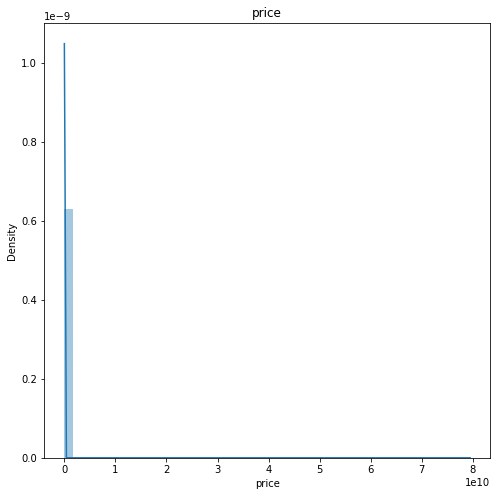

In [25]:
plt_numeric('price')

#### <font color=red>we can see that the price is highly skewed; so, let's do the log transformation</font>

In [26]:
import numpy as np

In [27]:
train_df['log_price'] = np.log1p(train_df['price'])

/Users/lpcheung/opt/anaconda3/envs/kaggle/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


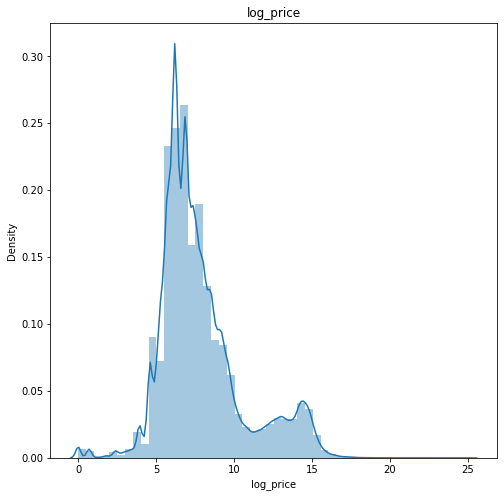

In [28]:
plt_numeric('log_price')

## 4. Target Check

/Users/lpcheung/opt/anaconda3/envs/kaggle/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


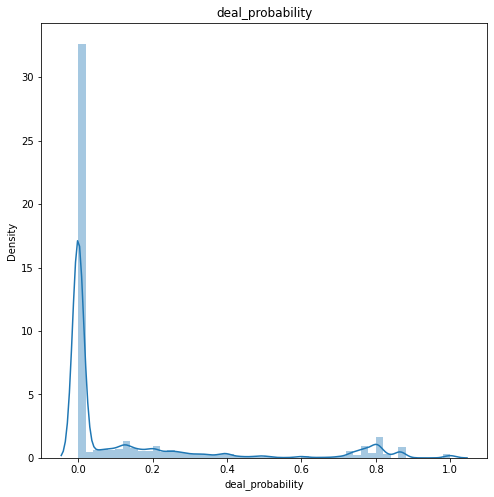

In [29]:
plt_numeric('deal_probability')

In [30]:
(train_df['deal_probability'] == 0).value_counts()

True     974618
False    528806
Name: deal_probability, dtype: int64

#### <font color=red>observation: most are 0, and there is another peak at 0.8</font>

## 5. Outlier Detection

#### <font color=red>suggestion: since price is a numeric feature, we detect the outlier for it</font>

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
scaler = StandardScaler()

In [33]:
train_df['log_price_ss'] = scaler.fit_transform(train_df['log_price'].values.reshape(-1, 1))

/Users/lpcheung/opt/anaconda3/envs/kaggle/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


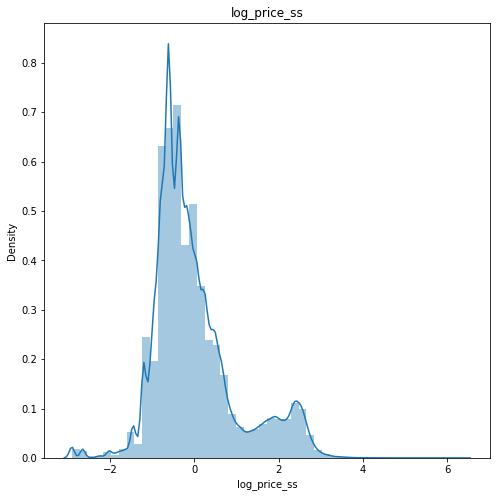

In [34]:
plt_numeric('log_price_ss')

In [35]:
train_df['log_price_ss'].sort_values(ascending = False)

1418253    6.361011
958131     5.002342
1223334    4.920016
47509      4.804532
861574     4.781770
             ...   
1503319         NaN
1503328         NaN
1503350         NaN
1503396         NaN
1503421         NaN
Name: log_price_ss, Length: 1503424, dtype: float64

#### <font color=red>observation: some records are obviously deviated from the mean</font>

#### <font color=red>suggestion: followup action depends on the algorithm we are going to use</font>

 - if you want to use tree family, no action is needed
 - if you want to use linear model or deep learning, cap them or remove them

## 6. Duplication Detection

In [36]:
train_df.duplicated().value_counts()

False    1503424
dtype: int64

#### <font color=red>observation: no duplicated rows</font>

## 7. Missing Value Detection

In [37]:
import missingno as msno

<AxesSubplot:>

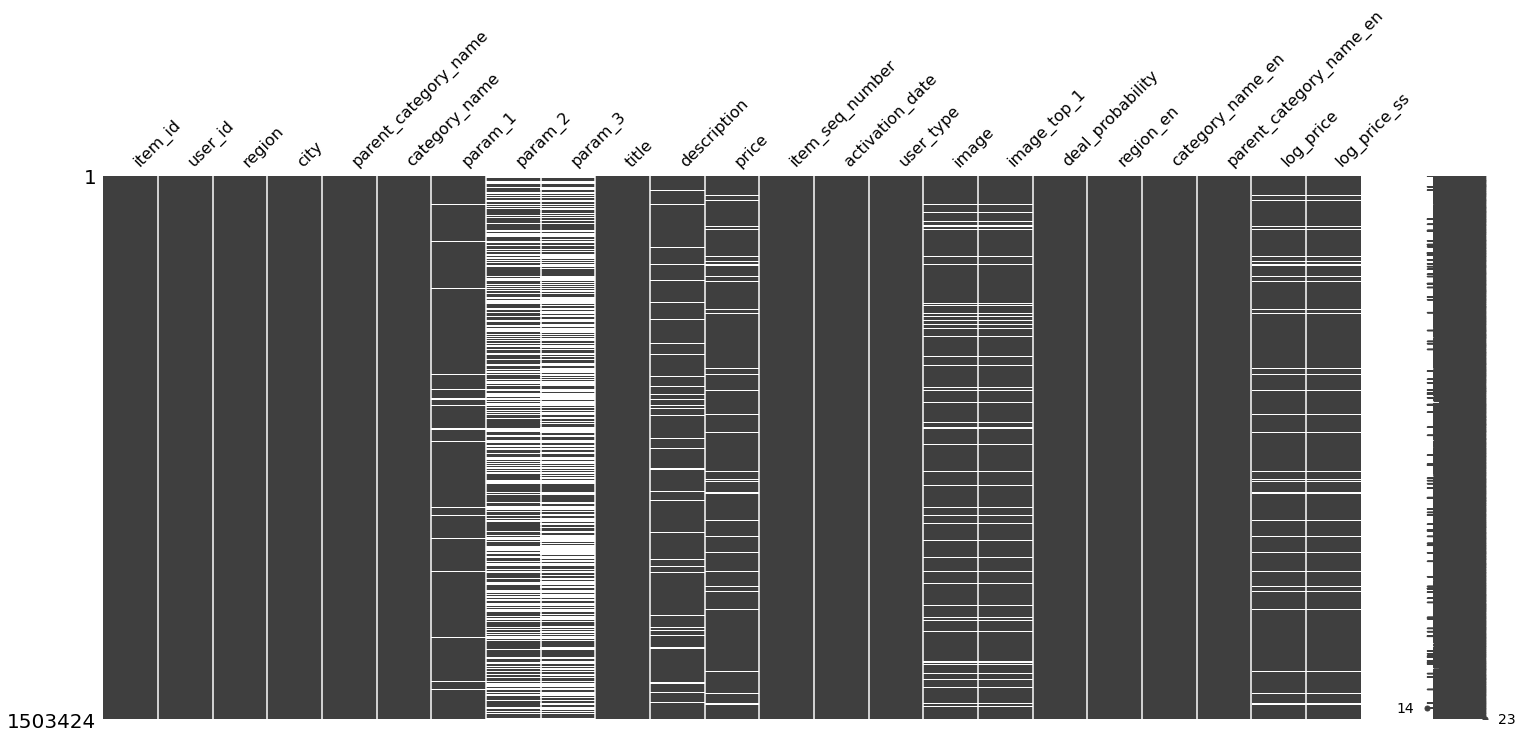

In [38]:
msno.matrix(train_df)

#### <font color=red>observation: only param_2, param_3 have lots of missing values, other features are OK</font>

#### <font color=red>suggestion: followup action depends on the algorithm you are going to use</font>

- some algorithms, like lightgbm, can handle missing values in itself
- many algorithms, like linear regression, cannot handle missing values so you need to fill in before training

#### <font color=red>suggestion: fill categorical missing values with "others"</font>

In [39]:
for each in ['region_en', 'city', 'parent_category_name_en', 'category_name_en', 
             'user_type', 'param_1', 'param_2', 'param_3']:
    train_df[each].fillna('other', inplace = True)

<AxesSubplot:>

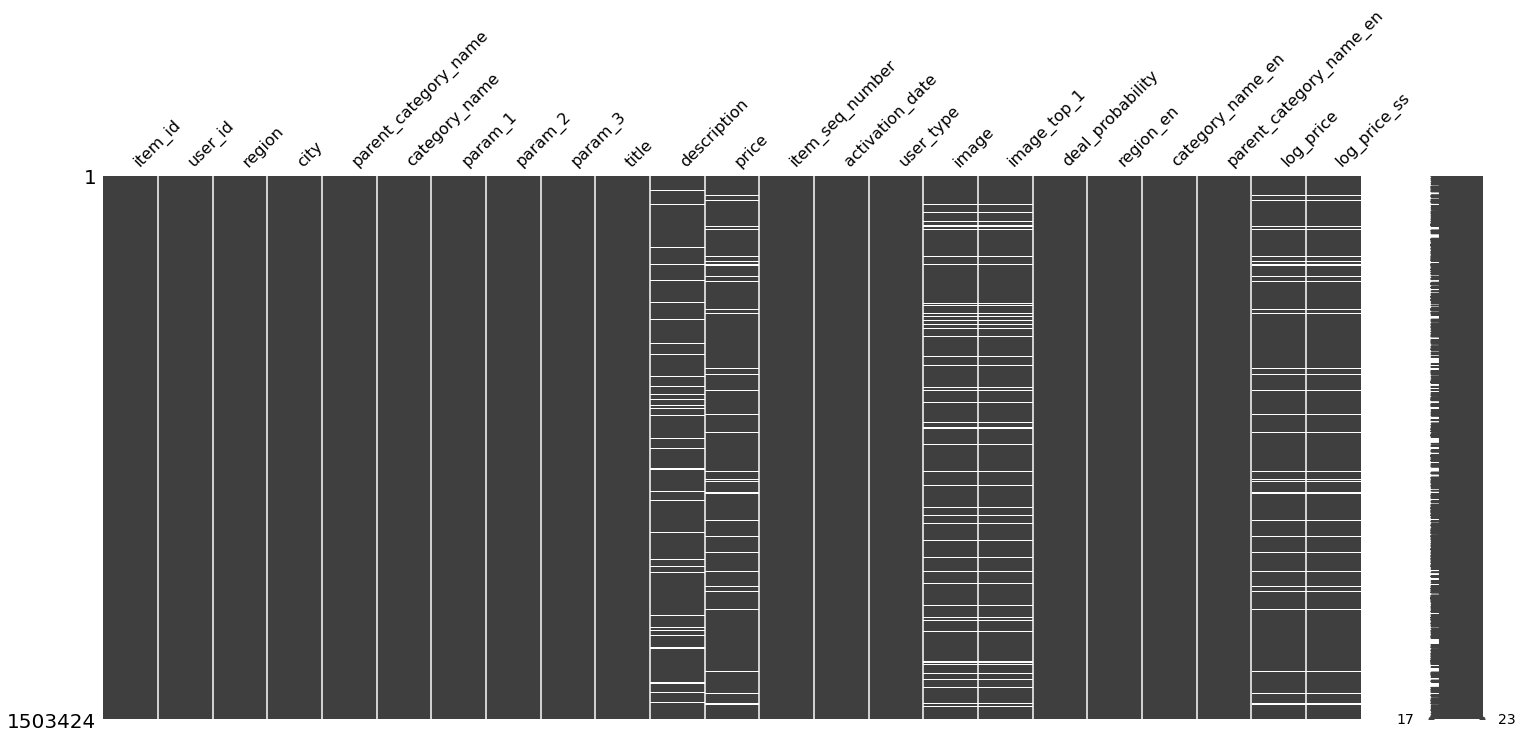

In [40]:
msno.matrix(train_df)

#### <font color=red>suggestion: fill numeric missing values with median</font>

In [41]:
for each in ['price', 'log_price', 'log_price_ss']:
    median = train_df[each].median()
    train_df[each].fillna(median, inplace = True)
    print (f'the median of {each} is {median}')

the median of price is 1300.0
the median of log_price is 7.170888478512505
the median of log_price_ss is -0.25343148889863665


<AxesSubplot:>

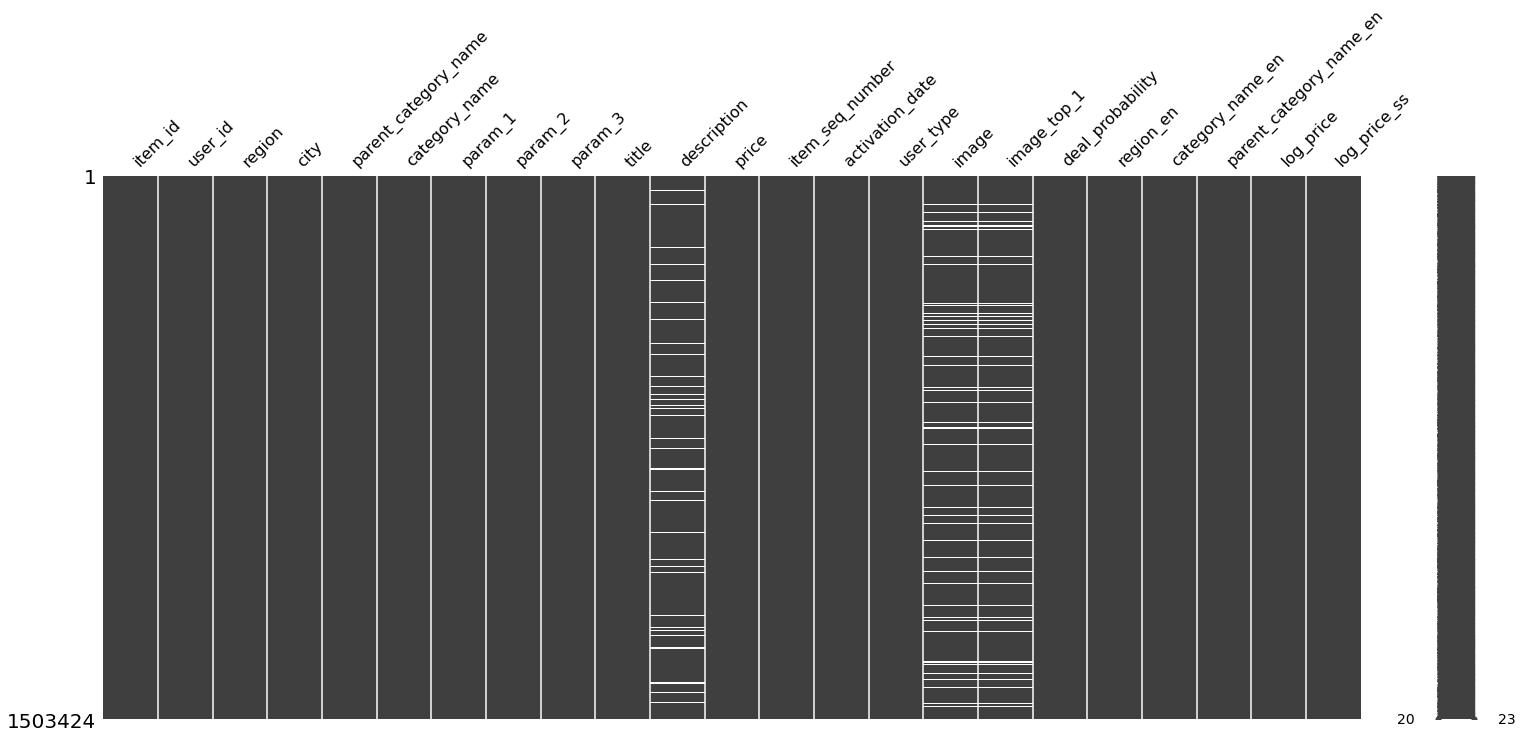

In [42]:
msno.matrix(train_df)

#### <font color=red>suggestion: for text missing values, fill it with empty string</font>

In [43]:
train_df['description'].fillna('', inplace = True)

<AxesSubplot:>

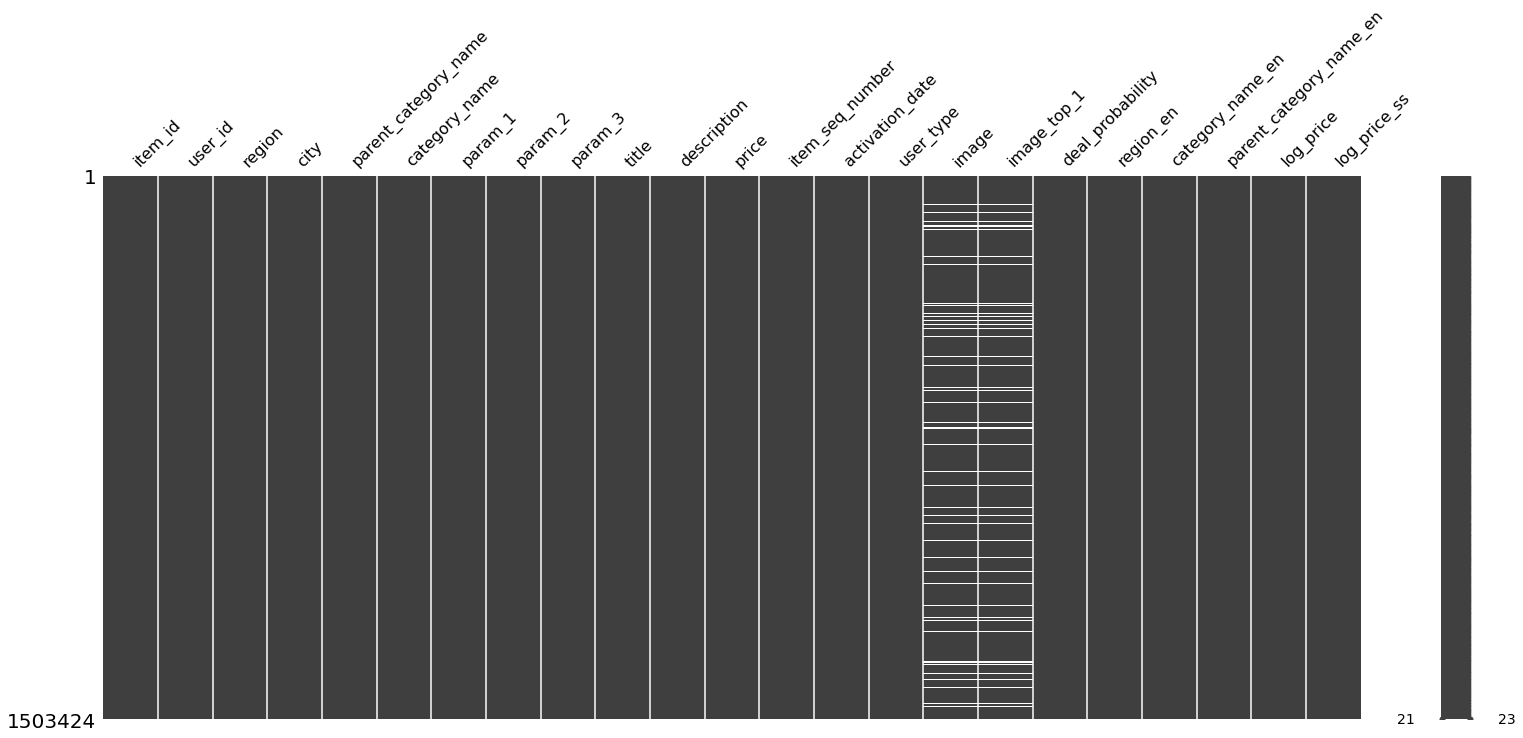

In [44]:
msno.matrix(train_df)

#### <font color=red>suggestion: we just ignore the image information this time for the sake of simplicity</font>

## 8. Re-formatting

In [45]:
train_df.dtypes

item_id                            object
user_id                            object
region                             object
city                               object
parent_category_name               object
category_name                      object
param_1                            object
param_2                            object
param_3                            object
title                              object
description                        object
price                             float64
item_seq_number                     int64
activation_date            datetime64[ns]
user_type                          object
image                              object
image_top_1                       float64
deal_probability                  float64
region_en                          object
category_name_en                   object
parent_category_name_en            object
log_price                         float64
log_price_ss                      float64
dtype: object

#### <font color=red>suggestion: some string featurs are actually categorical, so better re-format them</font>

In [46]:
for each in ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'user_type', 
             'region_en', 'category_name_en', 'parent_category_name_en']:
    train_df[each] = train_df[each].astype('category')

In [47]:
train_df.dtypes

item_id                            object
user_id                            object
region                           category
city                             category
parent_category_name             category
category_name                    category
param_1                          category
param_2                          category
param_3                          category
title                              object
description                        object
price                             float64
item_seq_number                     int64
activation_date            datetime64[ns]
user_type                        category
image                              object
image_top_1                       float64
deal_probability                  float64
region_en                        category
category_name_en                 category
parent_category_name_en          category
log_price                         float64
log_price_ss                      float64
dtype: object

## 9. Encoding

#### <font color=red>suggestion: encode categorical data with Label Encoder</font>

In [48]:
from sklearn.preprocessing import LabelEncoder

In [49]:
label_encoders = {}

for each in train_df.dtypes[train_df.dtypes == 'category'].index:
    le = LabelEncoder()
    train_df[each] = le.fit_transform(train_df[each])
    label_encoders[each] = le

#### <font color=red>suggestion: encode text data with LDA</font>

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

pipe = Pipeline([('tfidf', TfidfVectorizer(max_features = 5000)), 
                 ('lda', LatentDirichletAllocation(n_components = 5, max_iter = 5, batch_size = 1024))])

In [51]:
lda_encoded = np.load('./lda_encoded_description.npy')

In [52]:
train_df[[f'description_encoded_{i}' for i in range(lda_encoded.shape[1])]] = lda_encoded

In [53]:
train_df

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,region_en,category_name_en,parent_category_name_en,log_price,log_price_ss,description_encoded_0,description_encoded_1,description_encoded_2,description_encoded_3,description_encoded_4
0,b912c3c6a6ad,e00f8ff2eaf9,19,460,4,42,249,107,1163,Кокоби(кокон для сна),...,19,10,5,5.993961,-0.687649,0.053992,0.393369,0.053578,0.443878,0.055184
1,2dac0150717d,39aeb48f0017,17,1300,2,22,122,107,1163,Стойка для Одежды,...,16,18,3,8.006701,0.054935,0.070213,0.071765,0.072869,0.070521,0.714633
2,ba83aefab5dc,91e2f88dd6e3,16,1276,0,2,84,107,1163,Philips bluray,...,15,3,1,8.294300,0.161042,0.055311,0.787925,0.052947,0.052803,0.051014
3,02996f1dd2ea,bf5cccea572d,21,940,4,42,38,107,1163,Автокресло,...,20,10,5,7.696667,-0.059450,0.089182,0.089251,0.643467,0.089587,0.088513
4,7c90be56d2ab,ef50846afc0b,4,317,6,0,278,119,44,"ВАЗ 2110, 2003",...,25,7,8,10.596660,1.010479,0.727511,0.068083,0.068117,0.068317,0.067972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503419,5e6b7f0f3f65,dd05217165ea,15,1153,4,10,105,193,71,Ботиночки,...,14,9,5,5.707110,-0.793480,0.200000,0.200000,0.200000,0.200000,0.200000
1503420,d1f0910d2126,dc23ef451c8a,9,723,7,34,269,222,1163,Натяжной потолок,...,8,28,7,5.303305,-0.942461,0.036659,0.458495,0.431715,0.036672,0.036459
1503421,bc04866bc803,66a7016a5995,1,137,5,15,258,3,1174,"4-к квартира, 83 м², 4/5 эт.",...,1,0,6,7.170888,-0.253431,0.035481,0.035652,0.858023,0.035454,0.035390
1503422,f782f2ad9349,2d3ac1f5a7b3,15,155,4,10,105,193,72,Туфли-балетки,...,14,9,5,5.860786,-0.736783,0.065303,0.064753,0.065067,0.065910,0.738967


## 10. Transformation

#### <font color=red>the most skewed feature (price) is already transformed to its standard score (log_price_ss)</font>

/Users/lpcheung/opt/anaconda3/envs/kaggle/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

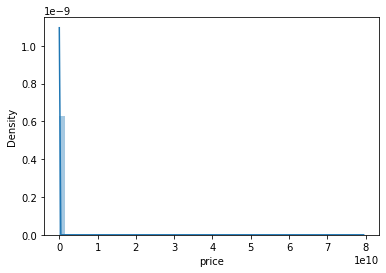

In [54]:
sns.distplot(train_df['price'])

/Users/lpcheung/opt/anaconda3/envs/kaggle/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_price_ss', ylabel='Density'>

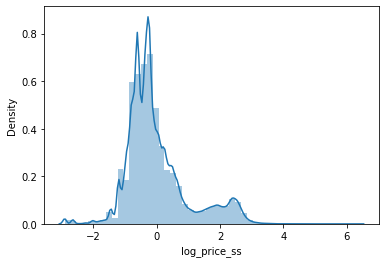

In [55]:
sns.distplot(train_df['log_price_ss'])

## 11. Feature Extraction



- you can build user level features like mean deal probability for user
- you can build item level features like mean deal probability for specific type of items

In [56]:
user_item_count = train_df['user_id'].value_counts()

In [57]:
sample = train_df[train_df['user_id'].isin(user_item_count[user_item_count > 10].index)]

/Users/lpcheung/opt/anaconda3/envs/kaggle/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='deal_probability', ylabel='Density'>

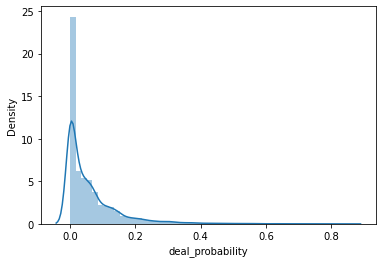

In [58]:
sns.distplot(sample.groupby('user_id')['deal_probability'].mean())

#### <font color=red>the mean probability for different sellers are highly diverse; so, it is a strong feature</font>

#### <font color=red>warning: be careful of data leakage!</font>

#### <font color=red>suggestion: extract the mean deal probability for each category and parent_catetory</font>

In [59]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,region_en,category_name_en,parent_category_name_en,log_price,log_price_ss,description_encoded_0,description_encoded_1,description_encoded_2,description_encoded_3,description_encoded_4
0,b912c3c6a6ad,e00f8ff2eaf9,19,460,4,42,249,107,1163,Кокоби(кокон для сна),...,19,10,5,5.993961,-0.687649,0.053992,0.393369,0.053578,0.443878,0.055184
1,2dac0150717d,39aeb48f0017,17,1300,2,22,122,107,1163,Стойка для Одежды,...,16,18,3,8.006701,0.054935,0.070213,0.071765,0.072869,0.070521,0.714633
2,ba83aefab5dc,91e2f88dd6e3,16,1276,0,2,84,107,1163,Philips bluray,...,15,3,1,8.294300,0.161042,0.055311,0.787925,0.052947,0.052803,0.051014
3,02996f1dd2ea,bf5cccea572d,21,940,4,42,38,107,1163,Автокресло,...,20,10,5,7.696667,-0.059450,0.089182,0.089251,0.643467,0.089587,0.088513
4,7c90be56d2ab,ef50846afc0b,4,317,6,0,278,119,44,"ВАЗ 2110, 2003",...,25,7,8,10.596660,1.010479,0.727511,0.068083,0.068117,0.068317,0.067972


In [60]:
category_name_probability_mapping = train_df.groupby('category_name')['deal_probability'].mean()

In [61]:
train_df['category_name_mean_prob'] = train_df['category_name'].map(category_name_probability_mapping)

In [62]:
parent_category_name_probability_mapping = train_df.groupby('parent_category_name')['deal_probability'].mean()

In [63]:
train_df['parent_category_name_mean_prob'] = train_df['parent_category_name'].map(parent_category_name_probability_mapping)

## 12. Modeling

#### <font color=red>suggestion: for simplicity, we use lightgbm</font>

In [64]:
import lightgbm as lgb

In [65]:
train_df.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability', 'region_en',
       'category_name_en', 'parent_category_name_en', 'log_price',
       'log_price_ss', 'description_encoded_0', 'description_encoded_1',
       'description_encoded_2', 'description_encoded_3',
       'description_encoded_4', 'category_name_mean_prob',
       'parent_category_name_mean_prob'],
      dtype='object')

In [66]:
independent_variables = ['region', 'city', 'parent_category_name',
                           'category_name', 'param_1', 'param_2', 'param_3', 'user_type',
                           'log_price_ss', 'description_encoded_0', 'description_encoded_1',
                           'description_encoded_2', 'description_encoded_3',
                           'description_encoded_4', 'category_name_mean_prob',
                           'parent_category_name_mean_prob']

dependent_variable = 'deal_probability'

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
users = train_df['user_id'].unique()

In [69]:
train_users, test_users = train_test_split(users, train_size = 0.8)

In [70]:
train = train_df[train_df['user_id'].isin(train_users)]
test = train_df[train_df['user_id'].isin(test_users)]

In [73]:
regressor = lgb.LGBMRegressor(max_depth = 5, objective = 'root_mean_squared_error', 
                              learning_rate=0.3, n_estimators=500)

regressor.fit(train[independent_variables], train[dependent_variable], 
              eval_set = (test[independent_variables], test[dependent_variable]), 
              early_stopping_rounds=20, 
              verbose = 50)

Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 0.232192
[100]	valid_0's rmse: 0.23121
[150]	valid_0's rmse: 0.230672
[200]	valid_0's rmse: 0.230362
[250]	valid_0's rmse: 0.23013
[300]	valid_0's rmse: 0.230022
[350]	valid_0's rmse: 0.229921
[400]	valid_0's rmse: 0.229875
Early stopping, best iteration is:
[392]	valid_0's rmse: 0.22987


LGBMRegressor(learning_rate=0.3, max_depth=5, n_estimators=500,
              objective='root_mean_squared_error')

## 13. Evaluation

In [74]:
prediction = regressor.predict(test[independent_variables])

In [75]:
prediction

array([0.13765397, 0.16184664, 0.4111413 , ..., 0.02302004, 0.4691878 ,
       0.10025102])

In [76]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [77]:
rmse = sqrt(mean_squared_error(test[dependent_variable].values, prediction))

In [80]:
print (f'the RMSE is {rmse}')

the RMSE is 0.22987026439527128


In [81]:
from lightgbm import plot_importance

#### <font color=red>suggestion: plot the feature importance for explainability</font>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

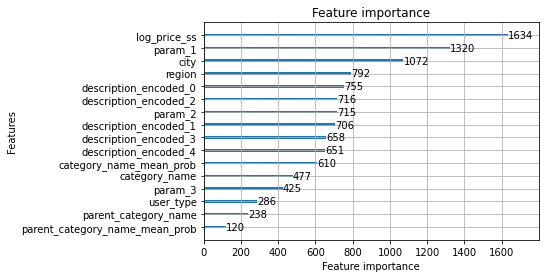

In [82]:
plot_importance(regressor)

#### <font color=red>Steps to improve:</font>
- try more algorithms
- fine tune the algorithm with different hyperparameter
- extract more features
    